# Creating PictoBERT

This notebook creates the basis of the PictoBERT models by instantiating BERT and changing its embeddings layer.

## ARES embeddings

ARES embeddings have two sides, one extracted from contextualized examples and another from gloss definition, both using BERT. We trained BERT using both sides as input embeddings. So these are our model variants: 1) contextualized and 2) gloss-based.

The vectors can be downloaded directly from the [ARES website](http://sensembert.org/) or by executing the following cell

In [2]:
!gdown https://drive.google.com/uc?id=1TU9Ar85Cs61owjy3GDsxPDaerYYNdIkl 
!gdown https://drive.google.com/uc?id=18ljLH7_z5CrcoRXNU6hOJbgxrZlhaRq9 

Downloading...
From: https://drive.google.com/uc?id=1TU9Ar85Cs61owjy3GDsxPDaerYYNdIkl
To: /root/capsule/ares_1024.bin
100%|█████████████████████████████████████████| 852M/852M [00:08<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=18ljLH7_z5CrcoRXNU6hOJbgxrZlhaRq9
To: /root/capsule/ares_1024_gloss.bin
100%|████████████████████████████████████████| 852M/852M [00:11<00:00, 72.1MB/s]


The cell above downloads the ARES side separately in binary format. It can be loaded using gensim.

In [4]:
from gensim.models import KeyedVectors

ares_contextual = KeyedVectors.load_word2vec_format("ares_1024.bin", binary=True)
ares_gloss = KeyedVectors.load_word2vec_format("ares_1024_gloss.bin", binary=True)

## Load Tokenizer

It is necessary to load our trained tokenizer to its vocabulary to update BERT.

In [5]:
!gdown https://drive.google.com/uc?id=1-2g-GCxjBwESqDn3JByAJABU9Dkuqy0m

Downloading...
From: https://drive.google.com/uc?id=1-2g-GCxjBwESqDn3JByAJABU9Dkuqy0m
To: /root/capsule/childes_all_new.json
100%|████████████████████████████████████████| 332k/332k [00:00<00:00, 9.34MB/s]


In [6]:
TOKENIZER_PATH = "./childes_all_new.json" # you can change this path to use your custom tokenizer

from transformers import PreTrainedTokenizerFast

loaded_tokenizer = PreTrainedTokenizerFast(tokenizer_file=TOKENIZER_PATH)
loaded_tokenizer.pad_token = "[PAD]"
loaded_tokenizer.sep_token = "[SEP]"
loaded_tokenizer.mask_token = "[MASK]"
loaded_tokenizer.cls_token = "[CLS]"
loaded_tokenizer.unk_token = "[UNK]"

## Load BERT

PictoBERT extends the BERT original weights. This way, we load BERT-large to use as base model.

In [7]:
from transformers import BertForMaskedLM, BertTokenizer

pretrained_w = 'bert-large-uncased'
tokenizer_bert = BertTokenizer.from_pretrained(pretrained_w)
base_model = BertForMaskedLM.from_pretrained(pretrained_w)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's use the copy library to make copies of BERT

In [8]:
import copy

contextualized_model = copy.copy(base_model)
gloss_based_model = copy.copy(base_model)

## Embeddings Update

#### Embeddings Update

The procedure for embeddings update is based on Algorithm 1.




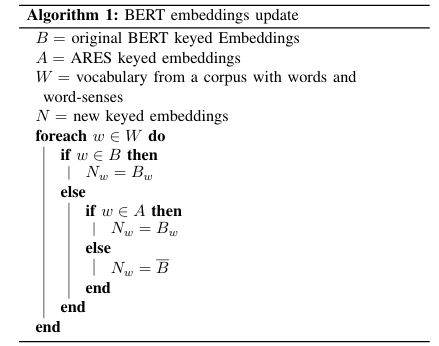

Let's calculate the mean vector of each ARES side,

In [9]:
import torch
ares_contextual_mean = torch.tensor(ares_contextual.vectors).mean(0)
ares_gloss_mean = torch.tensor(ares_gloss.vectors).mean(0)

Obtain the BERT old embeddings and vocabulary to use as a basis,

In [10]:
old_wgts = base_model.get_input_embeddings().weight.clone().detach()
old_vocab = tokenizer_bert.get_vocab()

Create the matrix that will receive the new embeddings,

In [11]:
new_vocab_size = len(loaded_tokenizer)
new_vocab = loaded_tokenizer.get_vocab()

new_wgts_contextual = old_wgts.new_zeros(new_vocab_size,old_wgts.size(1))
new_wgts_gloss = old_wgts.new_zeros(new_vocab_size,old_wgts.size(1))
new_wgts_contextual.size()

torch.Size([13583, 1024])

Populate the matrices,

In [12]:
from torch import tensor

for w,idx_new in new_vocab.items():
    idx_old = old_vocab.get(w, -1)
    if idx_old>=0:
      new_wgts_contextual[idx_new] = old_wgts[idx_old]
      new_wgts_gloss[idx_new] = old_wgts[idx_old]
    else:
      if w in ares_contextual:
          new_wgts_contextual[idx_new] = tensor(ares_contextual[w])
          new_wgts_gloss[idx_new] = tensor(ares_gloss[w])
      else:
          new_wgts_contextual[idx_new] = ares_contextual_mean
          new_wgts_gloss[idx_new] = ares_gloss_mean

And update the models embeddings layer.

In [13]:
from torch import nn
new_wte_contextual = nn.Embedding(new_vocab_size,old_wgts.size(1))
new_wte_gloss = nn.Embedding(new_vocab_size,old_wgts.size(1))

new_wte_contextual.weight.data.normal_(mean=0,std=base_model.config.initializer_range)
new_wte_contextual.weight.data = new_wgts_contextual

new_wte_gloss.weight.data.normal_(mean=0,std=base_model.config.initializer_range)
new_wte_gloss.weight.data = new_wgts_gloss

In [14]:
contextualized_model.resize_token_embeddings(len(loaded_tokenizer))
contextualized_model.set_input_embeddings(new_wte_contextual)
contextualized_model.set_output_embeddings(new_wte_contextual)

gloss_based_model.resize_token_embeddings(len(loaded_tokenizer))
gloss_based_model.set_input_embeddings(new_wte_gloss)
gloss_based_model.set_output_embeddings(new_wte_gloss)

### Saving models

The following cell save the PictoBERT (not trained yet) models.

In [15]:
contextualized_model.save_pretrained("./models/pictobert-large-contextual")
gloss_based_model.save_pretrained("./models/pictobert-large-gloss")